<a href="https://colab.research.google.com/github/Jakelinecs/Tareas-Machine-Learning/blob/main/N17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Iniciando entrenamiento de ScratchLogisticRegression...
Entrenamiento finalizado.

--- Métricas: Scratch Logistic Regression ---
Precisión (Accuracy): 0.9000
Precisión (Precision): 0.9286
Sensibilidad (Recall): 0.8667
Puntuación F1 (F1 Score): 0.8966

--- Métricas: Scikit-learn Logistic Regression ---
Precisión (Accuracy): 0.9000
Precisión (Precision): 0.9286
Sensibilidad (Recall): 0.8667
Puntuación F1 (F1 Score): 0.8966
✅ Pesos guardados en iris_logistic_weights.npz
✅ Pesos cargados desde iris_logistic_weights.npz


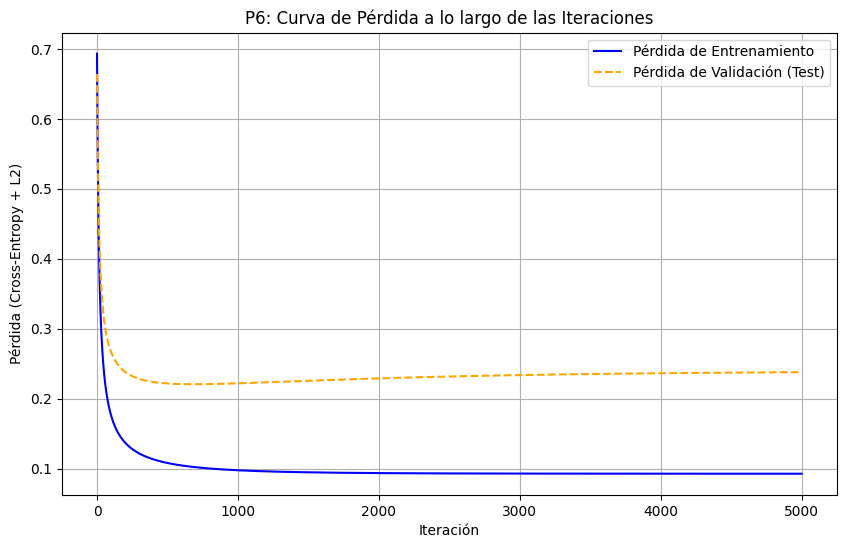

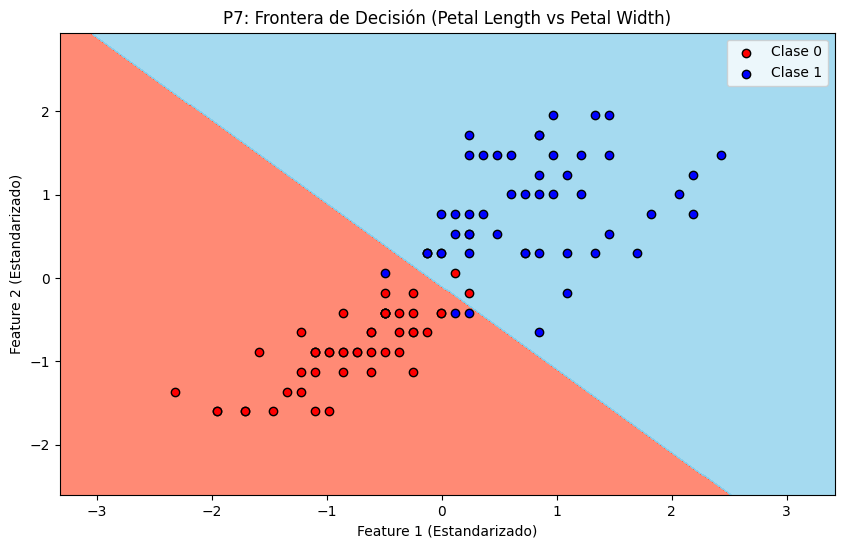

In [3]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression
from matplotlib.colors import ListedColormap

class ScratchLogisticRegression:

    def __init__(self, learning_rate=0.01, n_iterations=1000,
                 regularization_lambda=0.01, threshold=0.5):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.regularization_lambda = regularization_lambda
        self.threshold = threshold
        self.coef_ = None
        self.intercept_ = None
        self.loss_history = []
        # CORRECCIÓN AÑADIDA: Historial de pérdida de validación
        self.val_loss_history = []

    def _add_bias(self, X):
        return np.hstack([np.ones((X.shape[0], 1)), X])

    # P1:
    def _logistic_hypothesis(self, X):
        W = np.concatenate([self.intercept_, self.coef_])

        linear_model = X @ W
        return 1 / (1 + np.exp(-linear_model))

    # P4:
    def _loss_function(self, y_pred, y, X_with_bias):
        """
        Calcula la función de pérdida J(theta) (Cross-Entropy + L2).
        """
        m = len(y)
        # Asegurarse de que coef_ esté disponible para el término L2
        if self.coef_ is None:
            l2_term = 0
        else:
            l2_term = (self.regularization_lambda / (2 * m)) * np.sum(self.coef_**2)

        y_pred_clipped = np.clip(y_pred, 1e-15, 1 - 1e-15)
        cross_entropy_loss = - (1/m) * np.sum(
            y * np.log(y_pred_clipped) + (1 - y) * np.log(1 - y_pred_clipped)
        )

        return cross_entropy_loss + l2_term

    # P2:
    def _gradient_descent(self, X, error):
        m = X.shape[0]

        gradient_intercept = (1/m) * np.sum(error)

        X_without_bias = X[:, 1:]
        gradient_weights = (1/m) * X_without_bias.T @ error

        regularization_term = (self.regularization_lambda / m) * self.coef_
        gradient_weights += regularization_term

        self.intercept_ -= self.learning_rate * gradient_intercept
        self.coef_ -= self.learning_rate * gradient_weights

    # CORRECCIÓN: Se añaden X_val e y_val como parámetros opcionales
    def fit(self, X, y, X_val=None, y_val=None):

        n_features = X.shape[1]
        self.coef_ = np.zeros(n_features)
        self.intercept_ = np.zeros(1)
        self.loss_history = []
        self.val_loss_history = [] # Reiniciar en cada fit

        X_with_bias = self._add_bias(X)

        # Preparar datos de validación/prueba
        X_val_with_bias = self._add_bias(X_val) if X_val is not None else None

        for _ in range(self.n_iterations):
            # 1. Paso de entrenamiento (cálculo de pérdida y actualización de pesos)
            y_pred_proba = self._logistic_hypothesis(X_with_bias)
            error = y_pred_proba - y
            self._gradient_descent(X_with_bias, error)

            # 2. Registrar pérdida de entrenamiento
            loss = self._loss_function(y_pred_proba, y, X_with_bias)
            self.loss_history.append(loss)

            # 3. Registrar pérdida de validación/prueba
            if X_val_with_bias is not None:
                y_val_pred_proba = self._logistic_hypothesis(X_val_with_bias)
                # OJO: La pérdida de validación se calcula SOLO sobre los datos de validación
                val_loss = self._loss_function(y_val_pred_proba, y_val, X_val_with_bias)
                self.val_loss_history.append(val_loss)


        return self

    # P3:
    def predict_proba(self, X):
        """Retorna las probabilidades de la clase 1 (P3)."""
        X_with_bias = self._add_bias(X)
        return self._logistic_hypothesis(X_with_bias)

    # P3:
    def predict(self, X):
        """Retorna la etiqueta binaria (0 o 1) aplicando el umbral (P3)."""
        probabilities = self.predict_proba(X)
        return (probabilities >= self.threshold).astype(int)

    # P8:
    def save_weights(self, filename="logistic_weights.npz"):
        """Guarda los pesos del modelo."""
        np.savez(filename, coef=self.coef_, intercept=self.intercept_)
        print(f"✅ Pesos guardados en {filename}")

    # P8:
    def load_weights(self, filename="logistic_weights.npz"):
        """Carga los pesos del modelo."""
        try:
            data = np.load(filename)
            self.coef_ = data['coef']
            self.intercept_ = data['intercept']
            print(f"✅ Pesos cargados desde {filename}")
        except FileNotFoundError:
            print(f"❌ Archivo {filename} no encontrado.")

def calculate_metrics(y_true, y_pred, model_name):
    print(f"\n--- Métricas: {model_name} ---")
    print(f"Precisión (Accuracy): {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precisión (Precision): {precision_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"Sensibilidad (Recall): {recall_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"Puntuación F1 (F1 Score): {f1_score(y_true, y_pred, zero_division=0):.4f}")

# CORRECCIÓN: Se modifica para aceptar ambas historias de pérdida
def plot_loss_curve(train_loss_history, val_loss_history=None):
    plt.figure(figsize=(10, 6))

    # Pérdida de Entrenamiento
    plt.plot(train_loss_history, label='Pérdida de Entrenamiento', color='blue')

    # Pérdida de Validación (si se proporciona)
    if val_loss_history is not None and len(val_loss_history) > 0:
        plt.plot(val_loss_history, label='Pérdida de Validación (Test)', color='orange', linestyle='--')

    plt.title('P6: Curva de Pérdida a lo largo de las Iteraciones')
    plt.xlabel('Iteración')
    plt.ylabel('Pérdida (Cross-Entropy + L2)')
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_decision_boundary(model, X, y, title):

    X_set, y_set = X, y
    X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                         np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))

    Z = model.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape)

    plt.figure(figsize=(10, 6))
    plt.contourf(X1, X2, Z, alpha = 0.75, cmap = ListedColormap(('tomato', 'skyblue')))
    plt.xlim(X1.min(), X1.max())
    plt.ylim(X2.min(), X2.max())

    for i, j in enumerate(np.unique(y_set)):
        plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                    color = ListedColormap(('red', 'blue'))(i), label = f'Clase {j}',
                    edgecolors='black', marker='o')

    plt.title(title)
    plt.xlabel('Feature 1 (Estandarizado)')
    plt.ylabel('Feature 2 (Estandarizado)')
    plt.legend()
    plt.show()

# 3. VERIFICACIÓN Y EJECUCIÓN DEL SPRINT
if __name__ == '__main__':
    iris = load_iris()
    X = iris.data
    y = iris.target

    X_binary = X[y >= 1]
    y_binary = y[y >= 1]

    y_binary[y_binary == 1] = 0
    y_binary[y_binary == 2] = 1

    X_viz = X_binary[:, [2, 3]]

    X_train, X_test, y_train, y_test = train_test_split(
        X_viz, y_binary, test_size=0.3, random_state=42, stratify=y_binary
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # P5:

    scratch_lr = ScratchLogisticRegression(
        learning_rate=0.1,
        n_iterations=5000,
        regularization_lambda=0.1
    )
    print("Iniciando entrenamiento de ScratchLogisticRegression...")
    # CORRECCIÓN: Pasar los datos de test (validación) a la función fit
    scratch_lr.fit(X_train_scaled, y_train, X_val=X_test_scaled, y_val=y_test)
    print("Entrenamiento finalizado.")

    y_pred_scratch = scratch_lr.predict(X_test_scaled)
    calculate_metrics(y_test, y_pred_scratch, "Scratch Logistic Regression")

    sklearn_lr = SklearnLogisticRegression(C=10.0, solver='liblinear', random_state=42)
    sklearn_lr.fit(X_train_scaled, y_train)
    y_pred_sklearn = sklearn_lr.predict(X_test_scaled)
    calculate_metrics(y_test, y_pred_sklearn, "Scikit-learn Logistic Regression")

    # P8:
    scratch_lr.save_weights("iris_logistic_weights.npz")

    loaded_lr = ScratchLogisticRegression()
    loaded_lr.load_weights("iris_logistic_weights.npz")

    # CORRECCIÓN: Llamar a la función con ambas historias de pérdida
    plot_loss_curve(scratch_lr.loss_history, scratch_lr.val_loss_history)

    # P7:
    full_lr = ScratchLogisticRegression(learning_rate=0.1, n_iterations=5000, regularization_lambda=0.1)
    full_lr.fit(scaler.fit_transform(X_viz), y_binary)

    plot_decision_boundary(
        full_lr,
        scaler.fit_transform(X_viz),
        y_binary,
        'P7: Frontera de Decisión (Petal Length vs Petal Width)'
    )